## Plot results

/Users/yxr/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


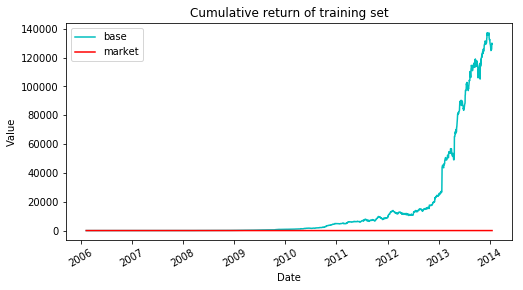

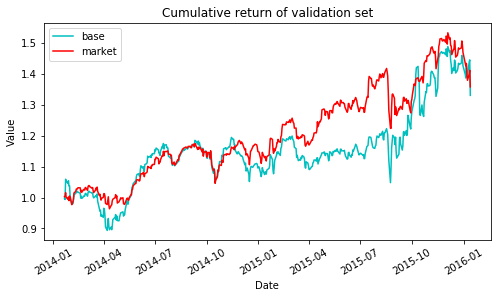

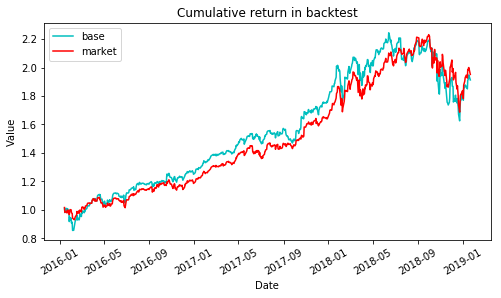

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from dataset import StockData
data = StockData('data.csv', features=['Open', 'High', 'Low', 'Close'])


def plot(df, title=''):
    df += 1
    df = df.cumprod(axis=0)
    start = df.index[0]
    end = df.index[-1] + 1
    market = data.UBAH(start, end)
    df.index=market.index # set index first
    df['market'] = market
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_title(title)
#     ax1.set_yscale('log')
    ax.set_title(title)
    for c in df.columns:
        if 'base' in c:
            color = 'c'
        elif 'market' in c:
            color = 'red'
        else:
            color = None
        ax.plot(df[c], color=color)
    ax.legend()
    return fig

def expand_dir(save_dir):
    sub_dirs = next(os.walk(save_dir))[1]
    if sub_dirs:
        return [save_dir.joinpath(sub) for sub in sub_dirs]
    else:
        return [save_dir]

def compare_with_base(save_dir, base_name='base'):
    test = {}
    save_dirs = expand_dir(Path(save_dir))
    for save_dir in save_dirs:
        name = os.path.basename(save_dir)
        test[name] = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col=0)['ret']
    test['CNN(base)'] = pd.read_csv('exp/base/test_summary.csv', index_col=0)['ret']
    fig3 = plot(pd.DataFrame(test), 'Cumulative return in backtest')


save_dir = Path('exp/base')

train = {}
valid = {}
test = {}
save_dirs = expand_dir(save_dir)
for save_dir in save_dirs:
    name = os.path.basename(save_dir)
    train[name] = pd.read_csv(save_dir.joinpath('train_last_epoch.csv'), index_col=0)['ret']
    valid[name] = pd.read_csv(save_dir.joinpath('valid_best_epoch.csv'), index_col=0)['ret']
    test[name] = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col=0)['ret']
fig1 = plot(pd.DataFrame(train), 'Cumulative return of training set')
fig2 = plot(pd.DataFrame(valid), 'Cumulative return of validation set')
fig3 = plot(pd.DataFrame(test), 'Cumulative return in backtest')


### network

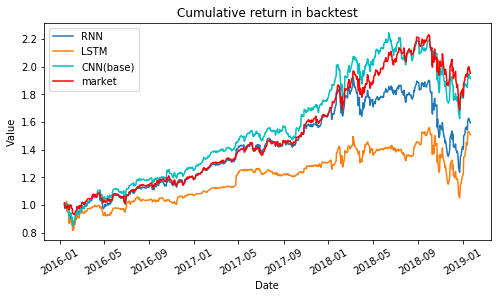

In [2]:
compare_with_base('exp/network', 'CNN(base)')

### output

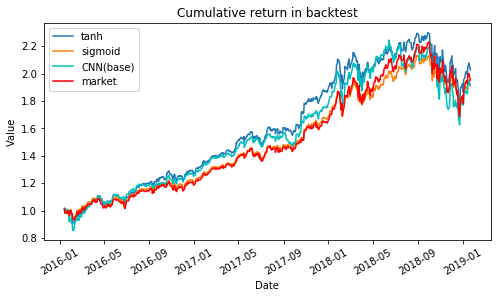

In [3]:
compare_with_base('exp/output', 'softmax(base)')

### online

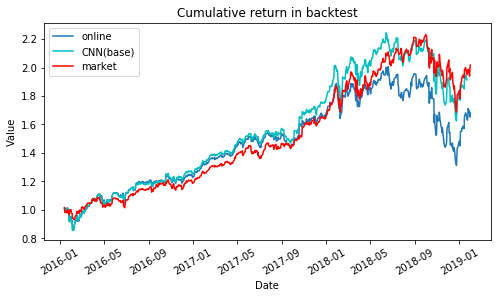

In [4]:
compare_with_base('exp/online')

### features

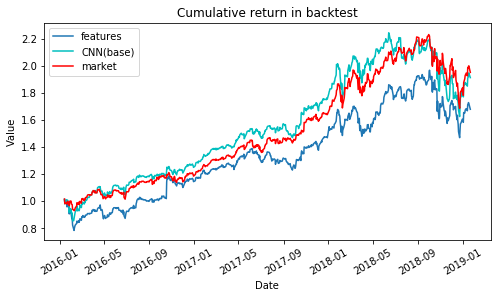

In [5]:
compare_with_base('exp/features', 'OHLC(base)')

### loss

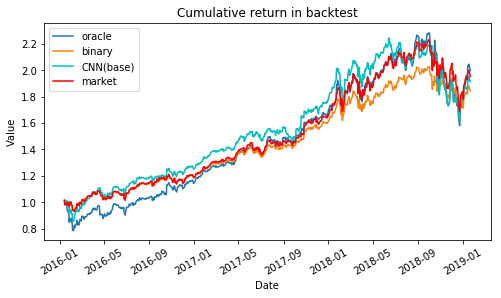

In [6]:
compare_with_base('exp/loss', 'return(base)')

### window

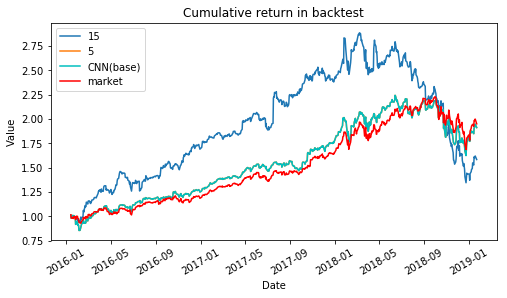

In [7]:
compare_with_base('exp/hyperparameters/window', '10(base)')

## Case Study
It's necessary to investigate the prediction on a single training/testing point because huge negative return is produced on some days.

### findings

1. output similar to one-hot encoding which means only one stock is held at a time
2. some stocks are much more likely to be chosen
3. a stock with with downtrend is still chosen

,ret
index,
3205,-0.090318
2513,-0.067909
3235,-0.058926
3195,-0.058435
2520,-0.054986
3223,-0.050426
3208,-0.047811
3023,-0.046277
3026,-0.046196


historical closing price:
[[ 0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -0.02 -0.01 -0.00  0.01 -0.03]
 [ 0.00 -0.03 -0.05 -0.03 -0.03 -0.08]
 [ 0.00 -0.03 -0.04 -0.02 -0.03 -0.09]
 [ 0.00 -0.01 -0.01 -0.02 -0.02 -0.06]
 [ 0.00 -0.01 -0.01 -0.00 -0.01 -0.04]
 [ 0.00 -0.03 -0.02 -0.01 -0.01 -0.06]
 [ 0.00 -0.02 -0.04 -0.02 -0.03 -0.08]
 [ 0.00 -0.02 -0.02 -0.01 -0.02 -0.08]
 [ 0.00 -0.05 -0.09 -0.10 -0.09 -0.17]
 [ 0.00 -0.00  0.02  0.01  0.02  0.04]]
price change:
[ 0.00 -0.03 -0.05 -0.06 -0.04 -0.03 -0.05 -0.05 -0.05 -0.09  0.03]
network output:
[0.00 0.00 0.01 0.01 0.02 0.01 0.01 0.01 0.01 0.93 0.00]
8
CDLENGULFING
4    100
dtype: int32


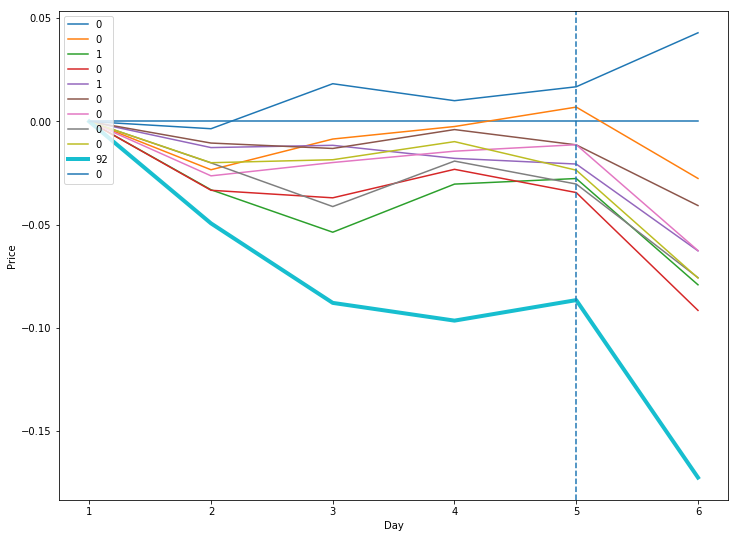

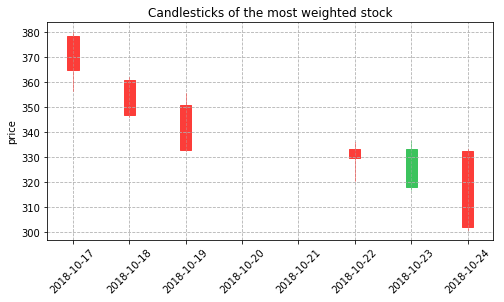

In [10]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num
import talib
from talib import abstract

idx = pd.IndexSlice
np.set_printoptions(precision=2, suppress=True, floatmode='fixed')



def candle(quotes, title):
    '''plot candlesticks'''
    fig, ax = plt.subplots(figsize=(8, 4))
    candlestick_ohlc(ax, quotes, colorup='#3cc35d', colordown='#fc3d39')
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.set_ylabel('price')
    ax.set_title(title)
    ax.grid(True, linestyle='--')
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(45)

def pattern(X):
    '''find out what pattern it is'''
    find = False
    X = X.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close'})
    for name in talib.get_function_groups()['Pattern Recognition']:
        f = abstract.Function(name)
        output = f(X)
        if np.any(output):
            find = True
            print('='*20)
            print(name)
            print(output[output!=0])
    if not find:
        print('No pattern found!')

def case(save_dir, k=0):
    # find extreme examples
    top = test_summary.sort_values(by='ret')
    display(top.head(10))
    index = top.index[k]

    # predict
    output = test_output.loc[index].values
    stock_idx = output.argmax()

    # print
    begin = index-data.window
    end = index+1
    X = data._historical_period(begin, end) # 3d, including price on current day
    y = data._price_change(index, end)[0]
    c = data._fi('Close')[0]
    closing = X[c]
    print("historical closing price:\n{}".format(closing))
    print("price change:\n{}".format(y,0))
    print("network output:\n{}".format(output))

    # plot
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    df = pd.DataFrame(closing).T
    df.index += 1
    # df.plot(ax=ax3)
    # convert raw output to portfolio weights
    weights = allocate(output)
    for i, c in enumerate(df.columns):
        if i == stock_idx:
            ax.plot(df[c], label='{:d}'.format(int(weights[i]*100)), linewidth=4.0)
        else:
            ax.plot(df[c], label='{:d}'.format(int(weights[i]*100)))
    ax.axvline(df.index[-2], linestyle='--')
    ax.legend(loc='upper left')
    
    # access data_raw directly instead of using X in order to get date and raw price
    if data.cash and stock_idx!=0:
        stock_idx -= 1
    print(stock_idx)
    best_stock = data.stocks[stock_idx]
    OHLC = data.data_raw.iloc[begin:end].loc[:,idx[['Open', 'High', 'Low', 'Close'], best_stock]]
    OHLC.columns = OHLC.columns.droplevel(1)
    OHLC.reset_index(inplace=True)
    OHLC.Date = date2num(OHLC.Date)
    candle(OHLC.values, title='Candlesticks of the most weighted stock')

    pattern(OHLC.iloc[:-1])

# restart the kernel after changing dir
save_dir = Path('exp/base')
os.environ['CONFIG_LOCAL_DIR'] = str(save_dir)
from config_global import data
from main import allocate
test_summary = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col='index')
test_output = pd.read_csv(save_dir.joinpath('test_output.csv'), index_col=0)

case(save_dir, 0)

Sharpe Ratio: 0.068
Maximum DrawDown: -0.276


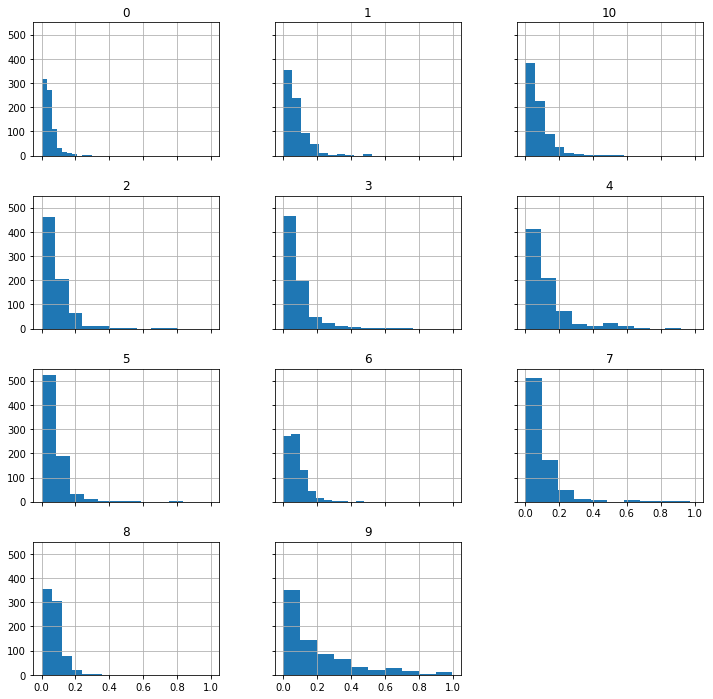

In [11]:
# compute sharpe ratio and max drawdown
ret = test_summary['ret']
SR = ret.mean()/ret.std() # std=0, almost impossible
ret = (ret + 1).cumprod()
MD = -np.max(1 - ret/np.maximum.accumulate(ret))
print('Sharpe Ratio: {:.3}\nMaximum DrawDown: {:.3}'.format(SR, MD))

# raw output distribution
asset_num = test_output.shape[1]
_ = test_output.hist(figsize=(min(asset_num*4, 12), (asset_num//3+1)*3), sharex=True, sharey=True)